### LBGM에 쓰이는 함수를 조금 추가하고 싶어서(정규화/표준화/차원축소) 따로 만들었음
### 기존의 전처리 함수 + 추가적 전처리 함수를 모아놓을 예정

### 21/01/01 설명서가 추가되었음
### 21/01/03 지금까지 것들 종합
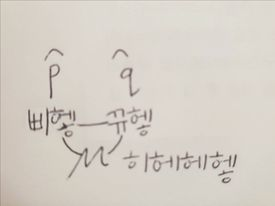

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame, concat
!pip install import_ipynb
import import_ipynb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=32e7f36d890ccc5160610c22e0600b9cbf11894453b3a750e31e3c472ded81ef
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#### 파라미터 ####

# 하루의 틱
ticks = 48

# 예측에 사용할 일수
days = 3                # 이 부분을 바꿀 수 있다.
n_days = ticks*days

# 미래 예측할 일수
future_days = 2
future_window = ticks * future_days

### 모든변수
# ['Hour', 'Minute', 'Day', 'WS', 'Time', 'DHI','DNI','RH','T','TARGET']

# 사용할 변수
what_to_left = ['Time', 'WS', 'DHI','DNI','RH','T','TARGET', 'Day']

n_features = len(what_to_left)
n_obs = n_days * n_features # 7일 예측 기준으로 7(일 수) * 48(틱 수) * 6(변수 개수)

In [ ]:
# Times and Columns
# Hour, Minute변수->Time 변수, +SH 변수 만드는 drop_clms 함수
# 사인 / 코사인 함수를 취해주고, 24시간 주기를 시계 모양으로 만들어준다.
# MakeAdjData 진행하였으면 쓸 일 없음. 데이터 자체를 adj버전으로 불러오면 됨


def drop_clms(dataset):
  dataset['Time'] = dataset['Hour'] + dataset['Minute']*(0.5/30)
  dataset = dataset[what_to_left]
  dataset['Date'] = dataset['Day']%365
  dataset.drop('Day', axis=1, inplace=True)

  # [SH] Sunny Hours
  temp = list()
  for i in range(0, len(dataset), 48):
    temp += [24-(list(dataset.DHI[i:i+48]).count(0)*0.5)]*48 

  dataset["SH"] = temp

  return dataset

def cos_time(dataset):
  dataset['sin_time'] = np.sin(2*np.pi*dataset.Time/24)
  dataset['cos_time'] = np.cos(2*np.pi*dataset.Time/24)

  dataset2 = dataset.drop('Time', axis = 1)
  return dataset2

def get_yday(when):
  HP = date(2020,1,1)
  results = (when-HP).days
  return results

def 절기24(Date):
  target = 0
  for i in list24:
    if Date < i:
      target = list24.index(i) - 1
      break
  if Date < 5:
    target = 23
  return target


In [ ]:
# 차원축소
# 원하는 변수의 숫자만큼 남긴다.
# dimension 변수에 원하는 변수의 숫자를 적어준다.

def alzip(dataset, dimension):
    X = dataset.iloc[:,:-1]
    y = dataset.iloc[:,-1:]
    pca = PCA(n_components= dimension)
    pca.fit(X)
    pica_X = pd.DataFrame(pca.transform(X), index = X.index)
    dataset2 = pd.concat([pica_X, y], axis = 1)
    return dataset2

In [ ]:
# 머신러닝에 쓰기 위해서 재정렬 시키는 series_to_supervised 함수

def series_to_supervised(data, n_in, target = 'TARGET', dropnan=True):
    df = DataFrame(data)
    df2 = DataFrame(data[target])
    cols, names = list(), list()
    future = [48,96]
    n_vars = 1 if type(df) is list else df.shape[1]
    n_vars2 = 1 if type(df2) is list else df2.shape[1]
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in future:
        cols.append(df2.shift(-i))
        if i == 0:
            names += [('TARGET%d(t)' % (j+1)) for j in range(n_vars2)]
        else:
            names += [('TARGET%d(t+%d)' % (j+1, i)) for j in range(n_vars2)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    else:
        agg.fillna(0,inplace=True)
    return agg

In [ ]:
# 머신러닝에 쓰기 위해서 재정렬 시키는 series_to_supervised 함수
# 스케일링을 하여 대입하는 경우에 사용됨.

def scale_to_supervised(train, test, n_in, target = 'TARGET', dropnan=True):
    df = DataFrame(train)
    df2 = pd.DataFrame(test, index = train.index)
    cols, names = list(), list()
    future = [48,96]
    n_vars = 1 if type(df) is list else df.shape[1]
    n_vars2 = 1 if type(df2) is list else df2.shape[1]
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in future:
        cols.append(df2.shift(-i))
        if i == 0:
            names += [('TARGET%d(t)' % (j+1)) for j in range(n_vars2)]
        else:
            names += [('TARGET%d(t+%d)' % (j+1, i)) for j in range(n_vars2)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    else:
        agg.fillna(0,inplace=True)
    return agg

In [ ]:
def seperator(dataset):
    # train_X, train_y, test_X, test_y로 분리하는 함수.

    X = dataset.iloc[:, :n_obs]
    Y1 = dataset.iloc[:, -2] #  2일동안 마지막 틱만 추출하여 예측값으로 설정한다. 
    Y2 = dataset.iloc[:, -1]

    # 7 : 3으로 Train Set :  Test Set을, 다시 7 : 3으로 Train Set을 나눈다.

    # X_train_1, X_test_1, Y_train_1,  Y_test_1 = train_test_split(X, Y1, test_size=0.30, random_state=42)
    # X_train_1, X_valid_1, Y_train_1,  Y_valid_1 = train_test_split(X_train_1, Y_train_1, test_size = 0.30, random_state=42)

    # X_train_2, X_test_2, Y_train_2,  Y_test_2 = train_test_split(X, Y2, test_size=0.30, random_state=42)
    # X_train_2, X_valid_2, Y_train_2,  Y_valid_2 = train_test_split(X_train_2, Y_train_2, test_size = 0.30, random_state=42)

    X_train_1, X_valid_1, Y_train_1,  Y_valid_1 = train_test_split(X, Y1, test_size=0.30, random_state=42)
    X_train_2, X_valid_2, Y_train_2,  Y_valid_2 = train_test_split(X, Y2, test_size=0.30, random_state=42)
    return X_train_1, X_valid_1, Y_train_1,  Y_valid_1, X_train_2, X_valid_2, Y_train_2,  Y_valid_2